In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#stylo data
link = 'https://drive.google.com/open?id=1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N'

fluff, id = link.split('=')
print(id)
filename = 'stylo-data-3.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

# data without stopwords
raw_data_link = 'https://drive.google.com/open?id=1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW'

#raw data text
#raw_data_link = 'https://drive.google.com/open?id=1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ'

fluff, id = raw_data_link.split('=')
print(id)
raw_filename = 'raw_data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(raw_filename)


1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N
1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW


In [0]:
# Download gloVe word embedding for portuguese-BR (100-dimensions)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

fluff, id = glove_50_link.split('=')
print(id)
glove_file_name = 'glove_s50.txt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(glove_file_name)
glove_file_name

10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz


'glove_s50.txt'

In [0]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

!pip install scikit-fuzzy
import skfuzzy as fuzz
from sklearn.cluster import MiniBatchKMeans

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer

import nltk
from nltk.cluster import KMeansClusterer
from sklearn import cluster, metrics
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# read dataset
df = pd.read_csv(filename)
raw_df = pd.read_csv(raw_filename)

# Remove single class entries (We need at least 3 samples of an author
df = df.groupby('Author').filter(lambda x: len(x) > 3)
y = df.pop('Author')
raw_df = raw_df.groupby('Author').filter(lambda x: len(x) > 3)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

le.fit(raw_df['Author'])
encoded_raw_Y = le.transform(raw_df['Author'])
raw_df['Author'] = encoded_raw_Y

In [0]:


# Load the embedding into a dictionary (eg: {'oi' : n1, n2, ..., n100})
word_embedding_dict = {}
with open(glove_file_name, 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)  
    coefs = np.fromstring(coefs, 'f', sep=' ')
    word_embedding_dict[word] = coefs

In [0]:
#word_embedding_dict.keys()

In [0]:
corpus = raw_df['Text']

# Create a Keras tokenizer and convert words to integer values
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)

# Convert strings to their corresponding integer value created by the Tokenizer
embedded_sentences = tokenizer.texts_to_sequences(corpus)
print(embedded_sentences)

max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
print(max_words_text)

max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
print(max_sentence_len)

padded_sentences = pad_sequences(embedded_sentences, max_sentence_len, padding='post')

print(padded_sentences.shape)
vocab_len = len(tokenizer.word_index) + 1

# Create an embedding matrix, in other words, use the weights from gloVe vector against all our corpus
# In the end we will have a matrix of all our vocabulary x 50 dimensions (size of glove dim)

# initialize with all zeros
embedding_matrix = np.zeros((vocab_len, 50))
for word, index in tokenizer.word_index.items():
  embedding_vector = word_embedding_dict.get(word)
  # if the word is in gloVe, we will use its weigths 
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector[:50]

#embedding_matrix


In [0]:
#tokenizer.word_index.items()

In [0]:
def build_weighted_document(padded_sentences):
  weigthed_documents = []
  for text in padded_sentences:
    document = np.zeros((vocab_len))
    embedding_vector = word_embedding_dict.get(text)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector[:50]
    weigthed_documents.append(document)

In [0]:
padded_sentences.shape

(69, 3913)

In [0]:
#Some clean-up on textual contents

raw_df = raw_df.replace(to_replace ='\r', value = ' ', regex = True) 
raw_df = raw_df.replace(to_replace ='\n ', value = '\n', regex = True) 
raw_df = raw_df.replace(to_replace ='\n{2,*}', value = ' ', regex = True) 

In [0]:
tagged_documents = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(raw_df['Text'])]

print (tagged_documents)

model = Doc2Vec(tagged_documents, vector_size=30, min_count=1, workers=4)

documents = [doc.words for doc in tagged_documents]
#print(documents)

In [0]:
#Verify top K features
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2


X = df.iloc[:,0:45]  #independent columns

bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))

                             Specs        Score
32                         HerdanV  1684.114969
5               StdevTamParagrafos  1221.210325
4           TamanhoMedioParagrafos   719.795449
29             TamanhoMaiorPalavra    93.471511
3                   StdevSentencas    83.923034
0                DiversidadeLexica    68.757992
2            TamanhoMedioSentencas    40.411601
34                         DugastU    39.514307
7                         Virgulas    12.684552
9                       DoisPontos     8.709682
6                            Ponto     8.680555
30                        GuiraudR     7.703381
8                      Exclamacoes     5.416670
20           PronomesPorPreposicao     4.343216
28  TamanhoMaisFrequenteDePalavras     2.651110
40                    BRFleshIndex     2.601753
1          TamanhoMedioDasPalavras     1.055664
24  FrequenciaDeHapaxLegomenaLocal     1.049860
36                        HonoresH     0.885296
10          FrequenciaDeParagrafos     0

HerdanC                           0.031669
Virgulas                          0.030777
FreqArt                           0.030335
HonoresH                          0.029272
StdevSentencas                    0.028982
FrequenciaDeHapaxLegomenaLocal    0.028112
TamanhoMedioDasPalavras           0.028023
Ponto                             0.027169
MaasA                             0.026732
FreqSubs                          0.025943
FrequenciaStopWords               0.025830
FrequenciaDeParagrafos            0.025577
FrequenciaDeBigrams               0.025428
DiversidadeLexica                 0.025314
FreqConj                          0.024852
HerdanV                           0.024782
FrequenciaPalavrasDuplicadas      0.024236
DugastU                           0.024171
FreqVerb                          0.023912
TamanhoMedioSentencas             0.023457
dtype: float64


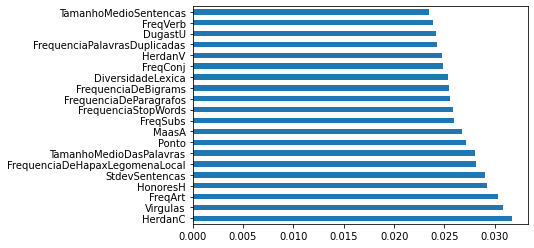

In [0]:
#Get most important stylometric features from Tree classifiers

model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances.nlargest(20))
plt.show()

In [0]:
feat_importances.nlargest(20)

HerdanC                           0.031669
Virgulas                          0.030777
FreqArt                           0.030335
HonoresH                          0.029272
StdevSentencas                    0.028982
FrequenciaDeHapaxLegomenaLocal    0.028112
TamanhoMedioDasPalavras           0.028023
Ponto                             0.027169
MaasA                             0.026732
FreqSubs                          0.025943
FrequenciaStopWords               0.025830
FrequenciaDeParagrafos            0.025577
FrequenciaDeBigrams               0.025428
DiversidadeLexica                 0.025314
FreqConj                          0.024852
HerdanV                           0.024782
FrequenciaPalavrasDuplicadas      0.024236
DugastU                           0.024171
FreqVerb                          0.023912
TamanhoMedioSentencas             0.023457
dtype: float64

In [0]:
# TD-IDF + Gaussian Mixture (Expectation-maximization) inference of best K


# !!!! Not working with TD-IDF, only for stylometric features (Too much RAM used)!!!


# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# from sklearn.model_selection import train_test_split
# from sklearn.cluster import KMeans
# import numpy as np
# from matplotlib import pyplot as plt

# gx = GaussianMixture()

# #gx.fit(df)
# n_components = np.arange(1, 10)
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_idf.toarray()) for n in n_components]
# plt.plot(n_components, [m.bic(df) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(df) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components')

In [0]:
# Create a wordcloud for each one of the authors

stopwords = set(nltk.corpus.stopwords.words('portuguese'))

def get_words(text):
  words = ' '.join(text)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  embedded_tokens = [token for token in tokens if token.lower() in word_embedding_dict.keys()]
  return " ".join(embedded_tokens)

def build_wordcloud(words, stopwords):
  return WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=500,
                      height=500
                     ).generate(get_words(words))

wcs = []
for i in range(0,11):
  wcs.append(build_wordcloud(raw_df.loc[raw_df['Author'] == i]['Text'], stopwords))

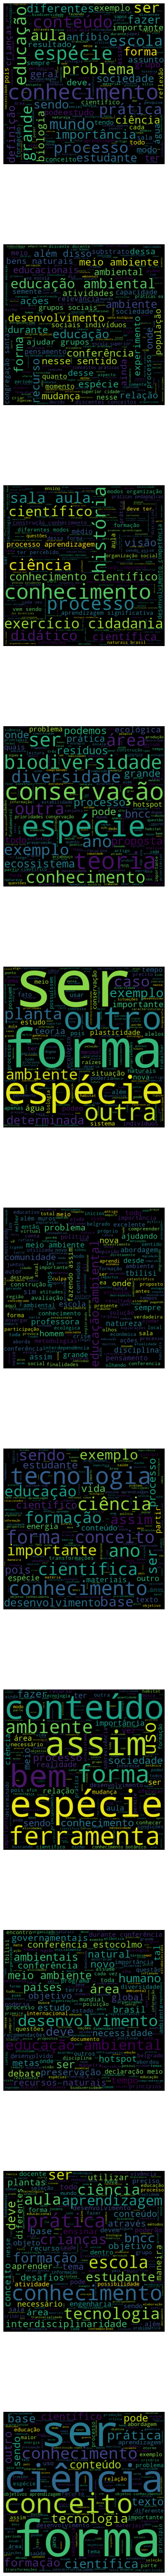

In [0]:
# Display Wordclouds
fig = plt.figure()
fig.set_figheight(100)
for idx, i  in enumerate(wcs):
    ax = fig.add_subplot(len(wcs),1,idx+1)
    wordcloud = i
    ax.imshow(wordcloud)
    ax.axis('off')

In [0]:
# Amount of works and valid tokens 

authors = {}
for i in range(0,11):
  author_texts = raw_df.loc[raw_df['Author'] == i]['Text']
  words = get_words(author_texts)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  tokens = [w for w in tokens if w.lower() not in stopwords]
  authors[le.inverse_transform([i])[0]] = (len(author_texts), len(tokens)) 

authors


{'bmm': (10, 3204),
 'fadj': (6, 3090),
 'flg': (4, 5609),
 'mj': (5, 2124),
 'pdje': (5, 1200),
 'sdcm': (4, 736),
 'sdeg': (8, 2753),
 'sdfi': (9, 2059),
 'sdjme': (7, 941),
 'sdlmm': (4, 1442),
 've': (7, 2435)}

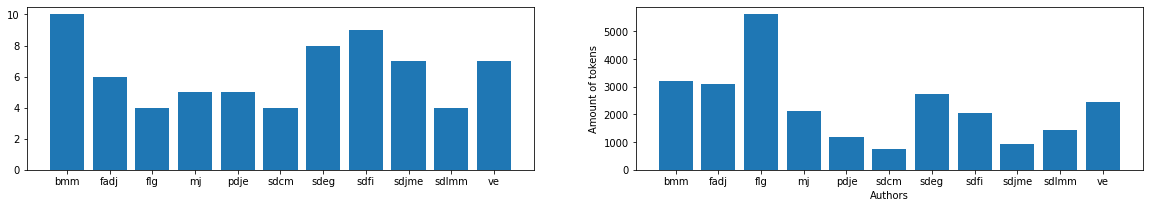

In [0]:
#Plot author works and the number of valid tokens

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

word_count = [size[1] for size in authors.values()]
X = authors.keys()
works_count =  [size[0] for size in authors.values()]
axes[0].bar(X,works_count)

plt.ylabel('Amount of tokens')
plt.xlabel('Authors')



axes[1].bar(X,word_count)
plt.show()


In [0]:
#Scale our data (Stylometric)

scaled_features = PowerTransformer().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [0]:
# Feature reduction PCA d=3 and Scaled features
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df.values)
df['PCA-one'] = pca_result[:,0]
df['PCA-two'] = pca_result[:,1] 
df['PCA-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.20634226 0.14916978 0.12222422]


In [0]:
le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

df['Author'] = encoded_Y

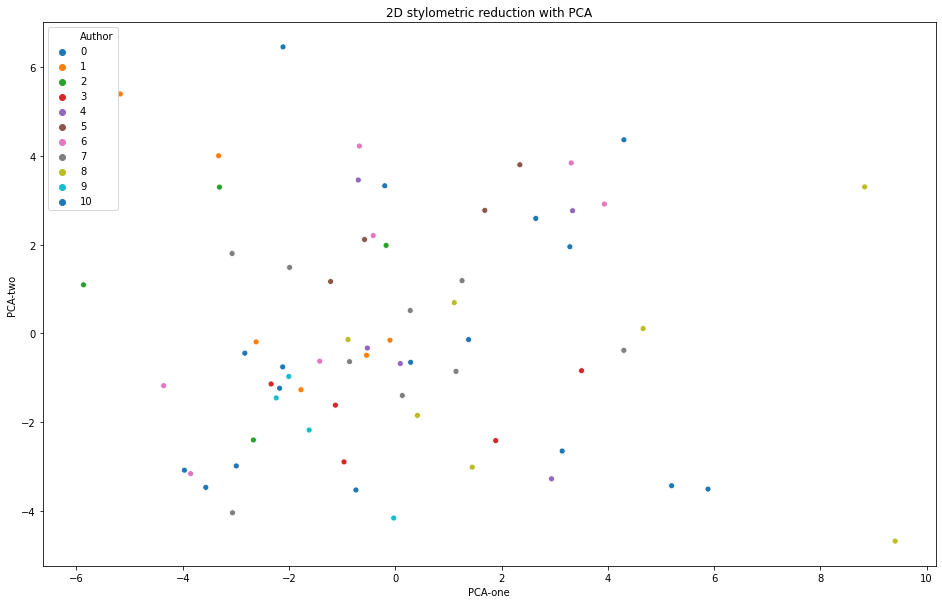

In [0]:
# Plot stylometric data on PCA-2D and Scaled features

plt.figure(figsize=(16,10))
plt.title('2D stylometric reduction with PCA')
sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="Author",
    palette=sns.color_palette("tab10", 11),
    data=df,
    legend="full"
)

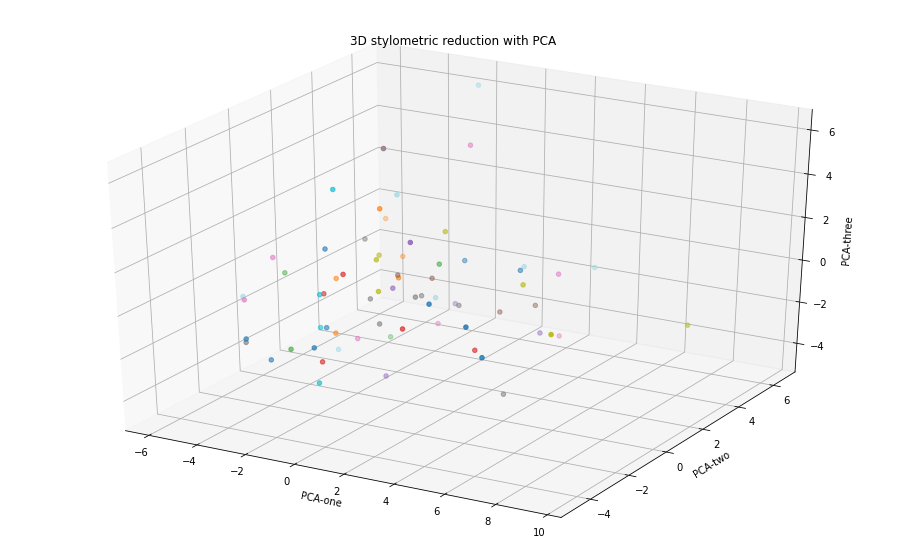

In [0]:
# Plot stylometric data on PCA-3D and Scaled features
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:]["PCA-one"], 
    ys=df.loc[:]["PCA-two"], 
    zs=df.loc[:]["PCA-three"], 
    c=df.loc[:]["Author"], 
    cmap='tab20',
)
ax.set_xlabel('PCA-one')
ax.set_ylabel('PCA-two')
ax.set_zlabel('PCA-three')

plt.title('3D stylometric reduction with PCA')
plt.show()

In [0]:
# Clear new df
df.pop('PCA-one')
df.pop('PCA-two')
df.pop('PCA-three')

1     -2.528536
2      0.591430
3      2.247828
5     -0.898374
6     -0.151875
         ...   
92    -2.452237
93    -0.240076
94    -1.047583
95    -0.953576
102   -4.621519
Name: PCA-three, Length: 69, dtype: float64

In [0]:
# Train model for TNSE reduction and Scaled features
y = df.pop('Author')
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['TSNE-2d-one'] = tsne_results[:,0]
df['TSNE-2d-two'] = tsne_results[:,1]
df['TSNE-2d-three'] = tsne_results[:,2]
df['Author'] = y

[t-SNE] Computing 68 nearest neighbors...
[t-SNE] Indexed 69 samples in 0.000s...
[t-SNE] Computed neighbors for 69 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 69 / 69
[t-SNE] Mean sigma: 4.735647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.743004
[t-SNE] KL divergence after 300 iterations: 3.255761
t-SNE done! Time elapsed: 0.17363715171813965 seconds


Text(0.5, 1.0, '2D stylometric reduction with TSNE')

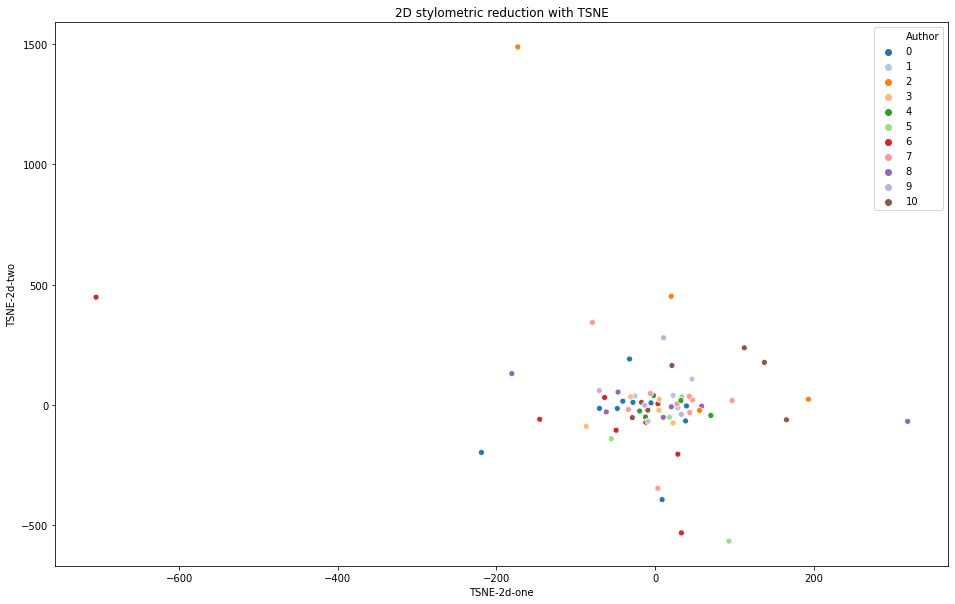

In [0]:
# Plot stylometric data on TSNE-2D and Scaled features
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="TSNE-2d-one", y="TSNE-2d-two",
    hue="Author",
    palette=sns.color_palette("tab20", 11),
    data=df,
    legend="full"
)
plt.title('2D stylometric reduction with TSNE')

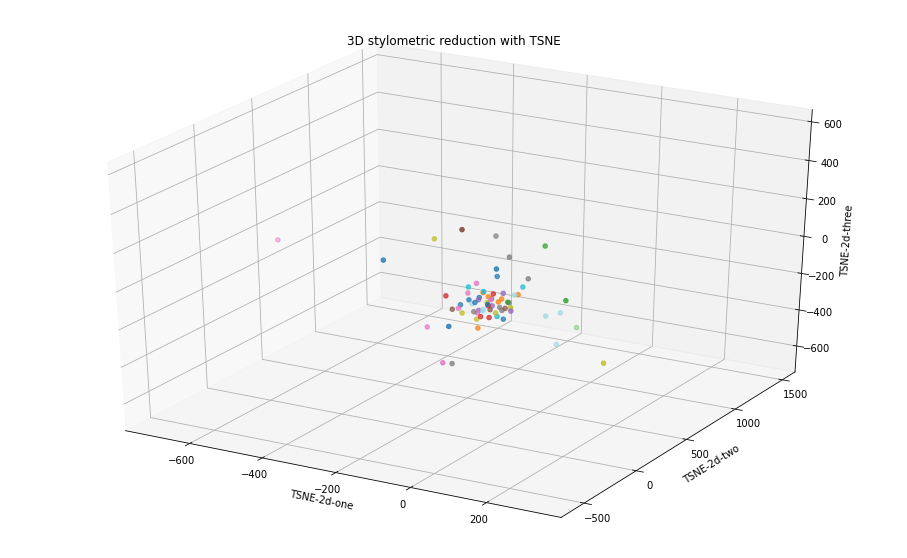

In [0]:
# Plot stylometric data on TSNE-3D and Scaled features

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:]["TSNE-2d-one"], 
    ys=df.loc[:]['TSNE-2d-two'], 
    zs=df.loc[:]['TSNE-2d-three'], 
    c=df.loc[:]["Author"], 
    cmap='tab20',
)
ax.set_xlabel('TSNE-2d-one')
ax.set_ylabel('TSNE-2d-two')
ax.set_zlabel('TSNE-2d-three')
plt.title('3D stylometric reduction with TSNE')

plt.show()